<a href="https://colab.research.google.com/github/nachozobian/computer-vision-PyTorch/blob/main/computer_vision_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch computer vision notebook

This notebook is just me taking my first steps with computer vision in PyTorch.

* `torchvision` is part of the PyTorch project for computer vision!
* `torchvision.datasets` get datasets and data loading functions
* `torchvision.models` get pretrained computer vision models
* `torchvision.transforms` manipulating your vision data to be suitable for ML
* `torch.utils.data.Dataset` Base dataset class for PyTorch
* `torch.utils.data.DataLoader` Python iterable object

In [ ]:
#Import PyTorch
import torch
from torch import nn

#Import Torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

#Import matplotlib for visualization
import matplotlib.pyplot as plt

## Dataset

We'll be using the Fashion MNIST dataset: https://github.com/zalandoresearch/fashion-mnist

To Serious Machine Learning Researchers
Seriously, we are talking about replacing MNIST. Here are some good reasons:

**MNIST is too easy.** Convolutional nets can achieve 99.7% on MNIST. Classic machine learning algorithms can also achieve 97% easily. Check out our side-by-side benchmark for Fashion-MNIST vs. MNIST, and read "Most pairs of MNIST digits can be distinguished pretty well by just one pixel."


**MNIST is overused.** In this April 2017 Twitter thread, Google Brain research scientist and deep learning expert Ian Goodfellow calls for people to move away from MNIST.

**MNIST can not represent modern CV tasks**, as noted in this April 2017 Twitter thread, deep learning expert/Keras author François Chollet.

In [ ]:
#Set up training data
train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = torchvision.transforms.ToTensor(),
    target_transform = None
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = torchvision.transforms.ToTensor(),
    target_transform = None
)

100%|██████████| 26421880/26421880 [00:02<00:00, 10361723.27it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 174772.78it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3238117.10it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19593717.78it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
### Input and output shape?

image, label = train_data[0]
class_names = train_data.classes
print(f"Image shape: {image.shape} -> [color, height, width]")
print(f"Label is: {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color, height, width]
Label is: Ankle boot


(-0.5, 27.5, 27.5, -0.5)

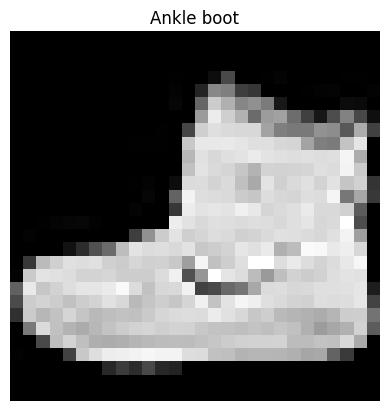

In [ ]:
### Visualizing data
import matplotlib.pyplot as plt
image, label = train_data[0]
class_names = train_data.classes
plt.imshow(image.squeeze(), cmap="gray") #We add the squeeze just because PyTorch understands images as NCHW and matplotlib as NHWC
plt.title(class_names[label])
plt.axis(False)

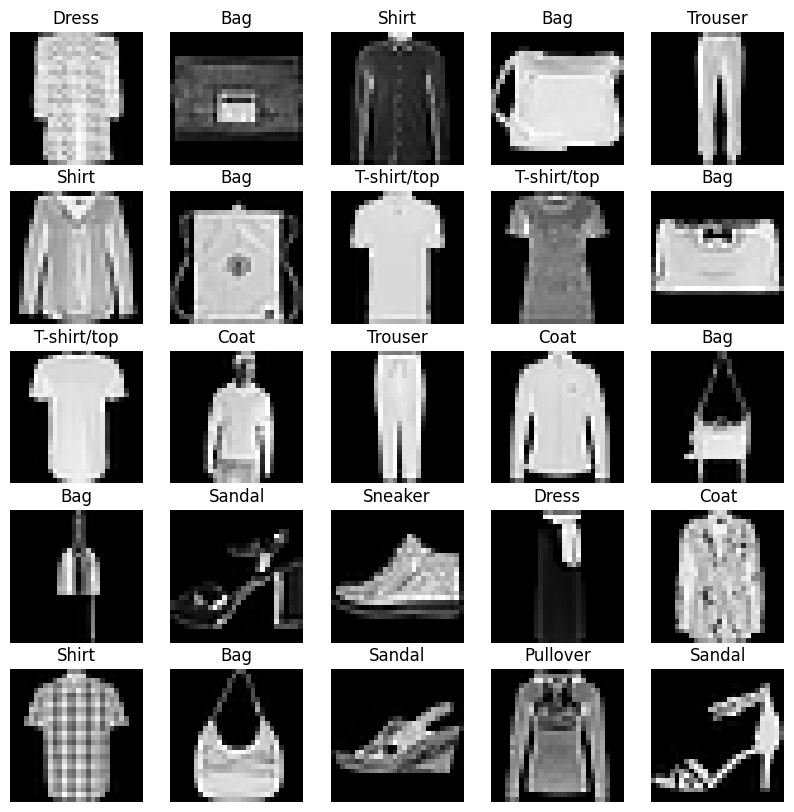

In [ ]:
torch.manual_seed(14)
fig = plt.figure(figsize = (10, 10))
rows,cols = 5,5
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0,len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

Now we want to turn our dataset into a Python iterable and for that we'll use DataLoader.

**We need to turn our data into batches (mini-batches). In order to process it more efficiently**

Dividing our data into mini-batches gives the algorithm more opportunities to update our gradient when looking at our data

In [ ]:
from torch.utils.data import DataLoader

## Divide our data into batches
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False)

##Creating a model

Baseline model: best practice!

A baseline model is a simple first approach model that will be improved iteratively.

In [ ]:
from torch import nn

class FashionMNISTModel0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_shape: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(), # This flatten layer will encode our [1,28,28] space into [1,28*28]
                      # so that we can  apply a Linear layer to the data.
        nn.Linear(in_features=input_shape,
                  out_features = hidden_shape),
        nn.Linear(in_features = hidden_shape,
                  out_features = output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(14)


model0 = FashionMNISTModel0(
    input_shape=784,
    hidden_shape = 10,
    output_shape = len(class_names)
).to("cpu")

model0

FashionMNISTModel0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

### Loss function, optimizer and metrics.

* Loss function: Since we're working with multi-class data, our loss function will be `nn.CrossEntropyLoss()`
* Optimizer: Stochastic Gradient Descent.
* Accuracy will be our evaluation metric.

In [ ]:
import requests
from pathlib import Path

#Download helper functions from repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exist, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)


In [ ]:
from helper_functions import accuracy_fn

#Set up loss function and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model0.parameters(),
                            lr = 0.1)

### Creating a function to time our experiments!

Two of the main thing you'll want to track are:
1. Model's performance (loss and accuracy values etc)
2. How fast it runs!

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time"""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

## Training our baseline model

We've splitted our data into batches so we've have to change something in our training procedure!

In [ ]:
#Import tqdm
from tqdm.auto import tqdm

#Seed and start the timer
torch.manual_seed(14)
train_time_start_on_cpu = timer()

epochs = 3

#Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch {epoch}\n--------")
  #Training
  train_loss = 0
  # Add a loop because our data is batchisized
  for batch, (X, y) in enumerate(train_dataloader):
    model0.train()
    y_pred = model0(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss #accumulate train loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)} / {len(train_dataloader.dataset)} samples.")

  #Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)
  ##Testing
  test_loss, test_acc = 0, 0
  model0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      test_pred = model0(X_test)

      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
  print(f"\n Train loss: {train_loss:.4f} |Test loss: {test_loss:.4f}, Test acc: {test_acc: .4f}")

train_time_end_on_cpu = timer()
total_train_time0 = print_train_time(start = train_time_start_on_cpu,
                                    end = train_time_end_on_cpu,
                                    device = str(next(model0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
--------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.

 Train loss: 0.5846 |Test loss: 0.6082, Test acc:  77.6657
Epoch 1
--------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.

 Train loss: 0.4737 |Test loss: 0.4884, Test acc:  83.0471
Epoch 2
--------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.

 Train loss: 0.4545 |Test loss: 0.4678, Test acc:  83.6761
Train time on cpu: 26.603 seconds


## Make prediction and get results !

In [ ]:
torch.manual_seed(14)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  loss, acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      y_pred = model(X)

      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true = y,
                         y_pred = y_pred.argmax(dim = 1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

model0_results = eval_model(model0, data_loader= test_dataloader,
                            loss_fn = loss_fn, accuracy_fn = accuracy_fn)
model0_results



{'model_name': 'FashionMNISTModel0',
 'model_loss': 0.46784767508506775,
 'model_acc': 83.67611821086263}

###  Setup device agnostic code

In [ ]:
!nvidia-smi

Wed Aug 23 07:08:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

## Improving our baseline model - Non Linearities!

Create a model with a non linear and linear Layers!

In [ ]:
#New model

class FashionMNISTModel1(nn.Module):
  def __init__(self,
               input_shape:int,
               hidden_units:int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(14)
model1 = FashionMNISTModel1(input_shape = 784,
                            hidden_units = 10,
                            output_shape=len(class_names)).to(device)

### Set up loss, optimizer and evaluation metrics.

In [ ]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss() # measure how  wrong our model is
optimizer = torch.optim.SGD(params = model1.parameters(),
                            lr = 0.1) # tries to improve our model parameters based on the loss

### Functionizing training and evaluation training/testing loops

In [ ]:
#Function for train loop - train_step
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim,
               accuracy_fn,
               device: torch.device = device):
  """Performs a training with model trying to learn on data_loader"""
  train_loss, train_acc = 0,0
  model.train()
  acc_loss = 0
  for batch, (X, y) in enumerate(data_loader):
    #Put data to device
    X, y  = X.to(device), y.to(device)

    #Forward pass
    y_pred = model(X)

    #Loss and accuracy per batch
    acc = accuracy_fn(y_true=y, y_pred = y_pred.argmax(dim=1))
    loss = loss_fn(y_pred, y)
    train_loss += loss #accumulate train loss
    acc_loss += acc

    #Optimizer zero grad
    optimizer.zero_grad()

    #Loss backward
    loss.backward()

    #Step in the optimizer direction
    optimizer.step()


  #Divide total train loss  and accuracy by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f}, | Train acc: {train_acc:.2f}\n")

In [ ]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """Performs a testing loop step on model going over data_loader"""
  test_loss, test_acc = 0,0
  model.eval()
  #Turn on inference mode context manager
  with torch.inference_mode():
    for X,y in data_loader:
      #Data to target device
      X,y = X.to(device), y.to(device)
      #Forward pass
      test_pred = model(X)
      #Calculate the loss
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred = test_pred.argmax(dim=1)) #goes from logits -> prediction labels

    #Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Train loss: {test_loss:.5f}, | Train acc: {test_acc:.2f}\n")

In [ ]:
torch.manual_seed(14)

#Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} \n--------------")
  train_step(model = model1,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer=optimizer,
             accuracy_fn = accuracy_fn,
             device = device)

  test_step(model=model1,
            data_loader= test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn= accuracy_fn,
            device=device)

train_time_end_on_gpu = timer()
total_train_time1 = print_train_time(start = train_time_start_on_gpu,
                                    end = train_time_end_on_gpu)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
--------------
Train loss: 1.23212, | Train acc: 0.00

Train loss: 1.03476, | Train acc: 64.82

Epoch: 1 
--------------
Train loss: 0.58372, | Train acc: 0.00

Train loss: 0.50696, | Train acc: 82.30

Epoch: 2 
--------------
Train loss: 0.47085, | Train acc: 0.00

Train loss: 0.47042, | Train acc: 83.33

Train time on None: 33.120 seconds


**Note:** Sometimes, depending on data/hardware, we might find that our model trains faster on CPU
than on the GPU.

Why is this?

1. It could be that the overhead for copying data overweights the compute benefits offered by the GPU (use copy/compute overlap)
2. Hardware CPU might be just better?

To read:


https://horace.io/brrr_intro.html

In [ ]:
#Migrating eval_model function to an agnostic version!

torch.manual_seed(14)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=device):
  loss, acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      #Device agnostic
      X, y = X.to(device), y.to(device)
      y_pred = model(X)

      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true = y,
                         y_pred = y_pred.argmax(dim = 1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

In [ ]:
model1_results = eval_model(model = model1,
                            data_loader = test_dataloader,
                            loss_fn  = loss_fn,
                            accuracy_fn = accuracy_fn,
                            device = device)

model1_results

{'model_name': 'FashionMNISTModel1',
 'model_loss': 0.4704159200191498,
 'model_acc': 83.32667731629392}

## Convolutional Neural Networks

Our non-linear model1 didnt quite make any difference. We'd rather take the linear model instead.

What about using a CNN? What even is a CNN?

> Typical CNN layers are Convolutional Layers, Pooling Layers and ReLU layers.
> The more layers you add the more possibilities your model has to learn, so normally the better your model is going to be.



In [ ]:
#Creating a CNN
class FashionMNISTModelV2(nn.Module):
  """
  Model architecture - TinyVGG
  """
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    #First block
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(
                  kernel_size = 2
        )
    )
    ##Second Block
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = output_shape,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(
                  kernel_size = 2
    )
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units * 7*7,
                  out_features = output_shape
                  )
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    return self.classifier(x)

In [ ]:
torch.manual_seed(42)
model2 = FashionMNISTModelV2(input_shape = 1,
                             hidden_units = 10,
                             output_shape = len(class_names)).to(device)

### Set up  a loss function and optimizer

In [ ]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model2.parameters(),
                            lr = 0.1)


### Build our training loop

In [ ]:
torch.manual_seed(14)
torch.cuda.manual_seed(14)

from timeit import default_timer as timer
train_time_start_model2 = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n---------------")
  train_step(model = model2,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device = device)
  test_step(model = model2,
            data_loader = test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn = accuracy_fn,
            device = device)

train_time_end_model2 = timer()
total_train_time_model2 = print_train_time(start = train_time_start_model2,
                                           end = train_time_end_model2,
                                           device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0
---------------
Train loss: 0.65698, | Train acc: 0.00

Train loss: 0.39910, | Train acc: 85.51

Epoch : 1
---------------
Train loss: 0.36499, | Train acc: 0.00

Train loss: 0.34827, | Train acc: 87.26

Epoch : 2
---------------
Train loss: 0.32679, | Train acc: 0.00

Train loss: 0.32204, | Train acc: 88.43

Train time on cuda: 40.496 seconds


In [ ]:
#Model 2 results.
model_2_results = eval_model(
    model = model2,
    data_loader = test_dataloader,
    loss_fn = loss_fn,
    accuracy_fn = accuracy_fn,
    device = device
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32203924655914307,
 'model_acc': 88.4285143769968}

## Compare the results and training time between our CNN model and our baseline model.

In [ ]:
import pandas as pd
compare_results = pd.DataFrame([model0_results,
                                model1_results,
                                model_2_results])
compare_results["training time"] = [total_train_time0,
                                    total_train_time1,
                                    total_train_time_model2]

compare_results

,model_name,model_loss,model_acc,training time
0,FashionMNISTModel0,0.467848,83.676118,26.602717
1,FashionMNISTModel1,0.470416,83.326677,33.120048
2,FashionMNISTModelV2,0.322039,88.428514,40.496062


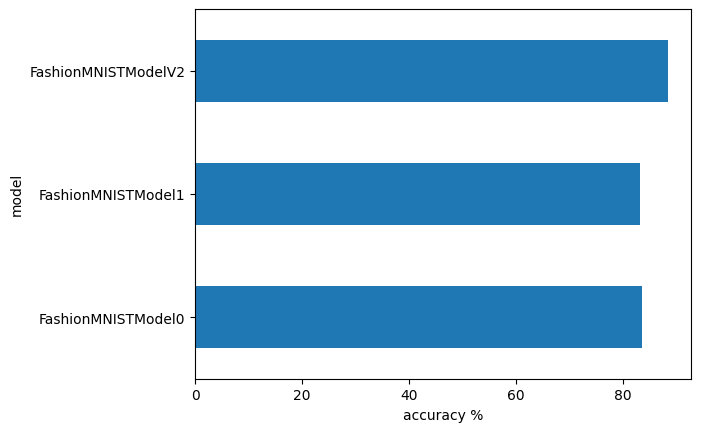

In [ ]:
#Visualizing model results.
compare_results.set_index("model_name")["model_acc"].plot(kind  = "barh")
plt.xlabel("accuracy %");
plt.ylabel("model");

In [ ]:
#Visual predictions on random samples.
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)
      pred_logit = model(sample)

      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      ## Get pred_prob off the GPU for using matplotlib library.
      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

import random
random.seed(14)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k = 9):
  test_samples.append(sample)
  test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

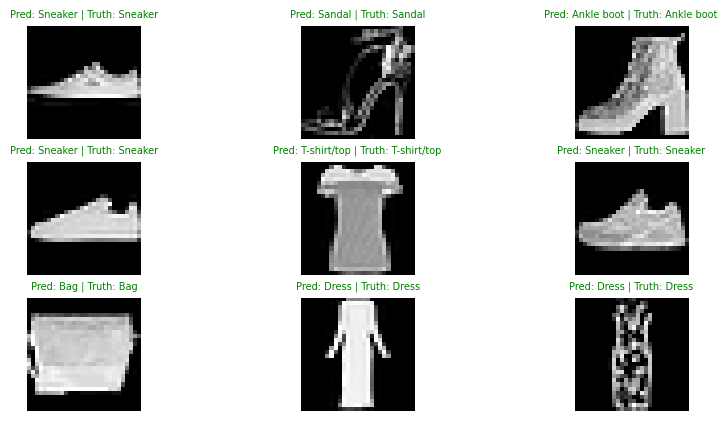

In [ ]:
#Make predictions.
pred_probs = make_predictions(model = model2,
                              data = test_samples)

pred_classes = pred_probs.argmax(dim=1)

plt.figure(figsize = (10, 5))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap = "gray")

  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]]

  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  plt.axis(False)
  if pred_label == truth_label:
    plt.title(title_text, fontsize = 7, c = "g")
  else:
    plt.title(title_text, fontsize = 7, c = "r")


## Visualizing our prediction evaluation

Making a confusion matrix to evaluate our classification model

1. Make predictions with our trained model
2. Make a confusion matrix
3. Plot it with `mlxtend.plotting.plot_confusion_matrix()`

In [ ]:
## Make predictions with out trained model
from tqdm.auto import tqdm

y_preds = []
model2.eval()
with torch.inference_mode():
  for X,y in tqdm(test_dataloader, desc = "Making predictions .."):
    X, y = X.to(device), y.to(device)
    y_logit = model2(X)
    y_pred = torch.softmax(y_logit.squeeze(), dim = 0).argmax(dim = 1)

    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)


Making predictions ..:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >= 19,"mlxtend should be 0.19.0 or higher"
except:
  !pip install torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 kB 11.6 MB/s eta 0:00:00
mlxtend version: 0.22.0


## Plotting Our Confusion Matrix

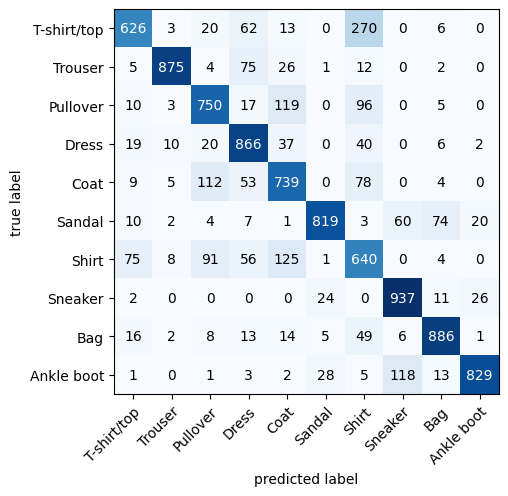

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds = y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix

fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_names,
    figsize = (8, 5)
)

The model seems to be doing pretty well.
It sometimes gets a bit mixed up between shirts and t-shirts, but that's not a major concern
for our first attempt at the PyTorch Computer Vision problem. We may need to fine-tune it a bit
more in the future.

For now, let's save our model.

## Save and load best performing model

In [ ]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model2.state_dict(),
           f=MODEL_SAVE_PATH)


Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [ ]:
#Create a new instance
torch.manual_seed(42)

loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     hidden_units = 10,
                                     output_shape=len(class_names))

loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model_2.to(device)

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32203924655914307,
 'model_acc': 88.4285143769968}

In [ ]:
#Evaluate loaded model

torch.manual_seed(42)
loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32203924655914307,
 'model_acc': 88.4285143769968}

In [ ]:
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-4)

tensor(True)